<a href="https://colab.research.google.com/github/joaowinderfeldbussolotto/assistente-ppc-ciencia-da-computacao/blob/main/tcc_evaluation_analysis_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p data
!cp -r /content/drive/My\ Drive/tcc/resultados/validados/deepeval/* data/


In [ ]:
import os
import glob

def get_latest_file(directory, pattern, ignore_files=None):
    if ignore_files is None:
        ignore_files = []

    file_list = glob.glob(os.path.join(directory, pattern))
    filtered_files = [f for f in file_list if os.path.basename(f) not in ignore_files]

    if not filtered_files:
        raise FileNotFoundError("No files found matching the pattern, excluding ignored files.")

    latest_file = max(filtered_files, key=os.path.getmtime)

    return latest_file


In [ ]:
base_directory = 'data/mistral-large-latest_/'
pattern = '*NAIVE*'


naive_latest_file = get_latest_file(base_directory, '*NAIVE_*', 'data/mistral-large-latest_/mistral-large-latest_7cedfd_NAIVE_03_11_2024_10-55-05.json')
naive_ft_latest_file = get_latest_file(base_directory, '*NAIVEFT*')
advanced_latest_file = get_latest_file(base_directory, '*ADVANCED*', 'data/mistral-large-latest_/mistral-large-latest_d6aa4d_ADVANCED_03_11_2024_00-51-59.json')

In [ ]:
naive_latest_file

'data/mistral-large-latest_/mistral-large-latest_b6d9bd_NAIVE_27_10_2024_14-45-57_combined.json'

In [ ]:
naive_ft_latest_file

'data/mistral-large-latest_/mistral-large-latest_c1096d_NAIVEFT_03_11_2024_10-55-05.json'

In [ ]:
advanced_latest_file

'data/mistral-large-latest_/mistral-large-latest_ba0259_ADVANCED_12_11_2024_22-21-09.json'

In [ ]:
import pandas as pd
from typing import Dict, Optional
import json

def filter_metrics(row):
    return [metric for metric in row if metric.get("score") != -1]


def rename_metrics(metric_name):
    lookup = {
        'Correctness (GEval)': 'Correção',
        'Answer Relevancy': 'Relevância da Resposta',
        'Contextual Recall': 'Recuperação Contextual',
        'Faithfulness': 'Fidelidade'
    }

    return lookup.get(metric_name)


def load_evaluation_df(file_path: str, thresholds: Optional[Dict[str, float]] = None) -> pd.DataFrame:
    """
    Carrega arquivo JSON de avaliação e retorna um DataFrame processado.

    Args:
        file_path (str): Caminho do arquivo JSON
        thresholds (Dict[str, float], optional): Dicionário com novos thresholds para cada métrica.
            Ex: {
                'Correctness (GEval)': 0.7,
                'Answer Relevancy': 0.6,
                'Contextual Recall': 0.3,
                'Faithfulness': 0.8
            }

    Returns:
        pd.DataFrame: DataFrame processado com os resultados
    """
    df = pd.read_json(file_path)

    if not thresholds:
        return df

    def recalculate_item_success(row):
        metrics = row['metrics']
        metric_successes = []

        for metric in metrics:
            metric_name = metric['name']
            if metric_name in thresholds:
                metric['threshold'] = thresholds[metric_name]
                metric['success'] = metric['score'] >= thresholds[metric_name]
                metric['name'] = rename_metrics(metric_name)
            else:
                metric['threshold'] = None
                metric['success'] = None
            metric_successes.append(metric['success'])

        row['success'] = all(metric_successes)
        return row

    df = df.apply(recalculate_item_success, axis=1)
    df["metrics"] = df["metrics"].apply(filter_metrics)

    # Update 'Documento' in additional_metadata
    def update_documento(row):
        if row.additional_metadata.get('Documento') == 'ppc2024':
            row.additional_metadata['Documento'] = 'ppc2025'
        return row

    df = df.apply(update_documento, axis=1)

    return df


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def extract_metrics(df, technique_name=None):
    """Extrai métricas do DataFrame e adiciona a técnica RAG se fornecida."""
    metrics_data = []
    for _, row in df.iterrows():
        for metric in row['metrics']:
            metrics_data.append({
                'metric_name': metric['name'],
                'score': metric['score'],
                'success': metric['success'],
                'technique': technique_name
            })
    return pd.DataFrame(metrics_data)

def clean_name(name):
    return name.rstrip('_')

def ensure_axes(axes):
    return np.array([axes]) if not isinstance(axes, np.ndarray) else axes

def plot_success_failure(dataframes_per_folder):
    fig, axes = plt.subplots(1, len(dataframes_per_folder), figsize=(20, 5), constrained_layout=True)
    axes = ensure_axes(axes)

    for idx, (model_name, df) in enumerate(dataframes_per_folder.items()):
        model = clean_name(model_name)
        df_metrics = extract_metrics(df)

        success_rate = df_metrics.groupby('metric_name')['success'].value_counts().unstack(fill_value=0)
        success_rate.plot(kind='barh', stacked=True, ax=axes[idx], color=['lightcoral', 'lightgreen'])
        axes[idx].set_xlabel('Count')
        axes[idx].set_ylabel('Metric Name')
        axes[idx].set_title(f'Success and Failure ({model})')

        for i, (metric, success) in enumerate(success_rate.iterrows()):
            total = success.sum()
            axes[idx].text(success[True] - 3, i, f'{int(success[True])} ({(success[True] / total) * 100:.1f}%)', va='center')

    plt.show()

def plot_average_scores(dataframes_per_folder):
    fig, axes = plt.subplots(1, len(dataframes_per_folder), figsize=(20, 5), constrained_layout=True)
    axes = ensure_axes(axes)

    for idx, (model_name, df) in enumerate(dataframes_per_folder.items()):
        model = clean_name(model_name)
        df_metrics = extract_metrics(df)

        avg_scores = df_metrics.groupby('metric_name')['score'].mean()
        bars = axes[idx].barh(avg_scores.index, avg_scores.values, color='lightblue')
        axes[idx].set_xlabel('Average Score')
        axes[idx].set_ylabel('Metric Name')
        axes[idx].set_title(f'Average Score ({model})')

        for bar in bars:
            axes[idx].text(bar.get_width() - 0.1, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

    plt.show()

def plot_score_distribution(dataframes_per_folder):
    fig, axes = plt.subplots(1, len(dataframes_per_folder), figsize=(20, 5), constrained_layout=True)
    axes = ensure_axes(axes)

    for idx, (model_name, df) in enumerate(dataframes_per_folder.items()):
        model = clean_name(model_name)
        df_metrics = extract_metrics(df)

        df_metrics['score'].plot(kind='hist', bins=10, ax=axes[idx], color='lightgreen', edgecolor='black')
        axes[idx].set_xlabel('Score')
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'Score Distribution ({model})')

    plt.show()

def plot_metric_comparison(rag_techniques):
    all_metrics = [extract_metrics(df, clean_name(tech_name)) for tech_name, df in rag_techniques.items()]
    combined_df = pd.concat(all_metrics)
    pivot_df = combined_df.pivot_table(values='score', index='metric_name', columns='technique', aggfunc='mean')

    ordered_columns = list(rag_techniques.keys())
    pivot_df = pivot_df[ordered_columns]

    ax = pivot_df.plot(kind='bar', figsize=(12, 7), color=['#8FB8DE', '#FEBF57', '#92C69D'], edgecolor='black')
    plt.xlabel('Métrica')
    plt.ylabel('Pontuação Média')
    plt.xticks(rotation=45)
    plt.legend(title='Implementações')

    for p in ax.patches:
        # Adjusting the annotation position
        ax.annotate(f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2, p.get_height() + 0.02),
                    ha='center', va='bottom', fontsize=10, color='black', weight='bold')

    plt.tight_layout()
    plt.show()




def combine_failed_inputs_with_ppc(rag_techniques):
    all_questions = []
    failed_questions = []

    for tech_name, df in rag_techniques.items():
        for _, row in df.iterrows():
            all_questions.append({'input': row['input'], 'PPC': row['additional_metadata'].get('Documento'), 'technique': clean_name(tech_name)})
            if any(not metric['success'] for metric in row['metrics']):
                failed_questions.append({'input': row['input'], 'PPC': row['additional_metadata'].get('Documento'), 'technique': clean_name(tech_name)})

    all_df = pd.DataFrame(all_questions)
    total_questions_per_ppc = all_df.groupby(['PPC', 'technique']).size()

    failed_df = pd.DataFrame(failed_questions)
    failures_per_ppc = failed_df.groupby(['PPC', 'technique']).size()

    failure_rate_per_technique = (failures_per_ppc / total_questions_per_ppc) * 100


    return failures_per_ppc, failure_rate_per_technique, total_questions_per_ppc



def extract_prompt_tokens(dataframe, technique_name):
    return pd.DataFrame([
        {'technique': technique_name, 'prompt_tokens': row['additional_metadata'].get('PromptTokens', 0)}
        for _, row in dataframe.iterrows()
    ])



def plot_token_statistics_table(rag_techniques):
    all_token_data = [
        extract_prompt_tokens(df, technique_name)
        for technique_name, df in rag_techniques.items()
    ]

    combined_token_df = pd.concat(all_token_data)
    token_stats = combined_token_df.groupby('technique')['prompt_tokens'].agg(['min', 'mean', 'max', 'sum']).round()

    ordered_techniques = list(rag_techniques.keys())
    token_stats = token_stats.reindex(ordered_techniques)

    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axis('off')  # Remover eixos

    table = ax.table(cellText=token_stats.values,
                     colLabels=["Mínimo", "Média", "Máximo", "Total"],
                     rowLabels=token_stats.index,
                     cellLoc='center', loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    for (i, j), cell in table.get_celld().items():
        cell.set_edgecolor("black")
        cell.set_linewidth(1.25)
        if i == 0 or j == -1:
            cell.set_facecolor("#4E79A7")
            cell.set_text_props(color="white", weight="bold")

    # plt.title("Estatísticas de Uso de Prompt Tokens por Implementação", fontsize=14)
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import pandas as pd

def clean_technique_name(name):
    return name.rstrip('_')

def plot_success_comparison_with_title(rag_techniques):
    """
    Plots success rates for different RAG techniques with enhanced visualization
    """
    success_data = []

    # Calculate success rates for each RAG technique
    for technique_name, df in rag_techniques.items():
        true_count = df['success'].value_counts().get(True, 0)
        total_count = len(df)
        percentage = (true_count / total_count) * 100
        success_data.append({
            'technique': clean_technique_name(technique_name),
            'success_count': true_count,
            'total_count': total_count,
            'percentage': percentage
        })

    success_df = pd.DataFrame(success_data)
    technique_order = list(rag_techniques.keys())
    success_df['technique'] = pd.Categorical(success_df['technique'], categories=technique_order, ordered=True)
    success_df = success_df.sort_values('technique')

    fig, ax = plt.subplots(figsize=(10, 6))

    bars = ax.bar(success_df['technique'],
                 success_df['percentage'],
                 color='#8FB8DE',
                 edgecolor='black',
                 width=0.6,
                 alpha=0.8)

    # ax.set_title('Taxa de Sucesso por Implementação',
    #             fontsize=14,
    #             pad=20,
    #             weight='bold')
    ax.set_xlabel('Implementação', fontsize=12, labelpad=10)
    ax.set_ylabel('Taxa de Sucesso (%)', fontsize=12, labelpad=10)

    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        idx = bars.index(bar)
        success_count = success_df.iloc[idx]['success_count']
        total_count = success_df.iloc[idx]['total_count']

        ax.text(bar.get_x() + bar.get_width()/2, height + 1,
                f'{height:.1f}%\n(n={success_count})',
                ha='center', va='bottom',
                fontsize=10)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

    plt.tight_layout()

    return fig, ax



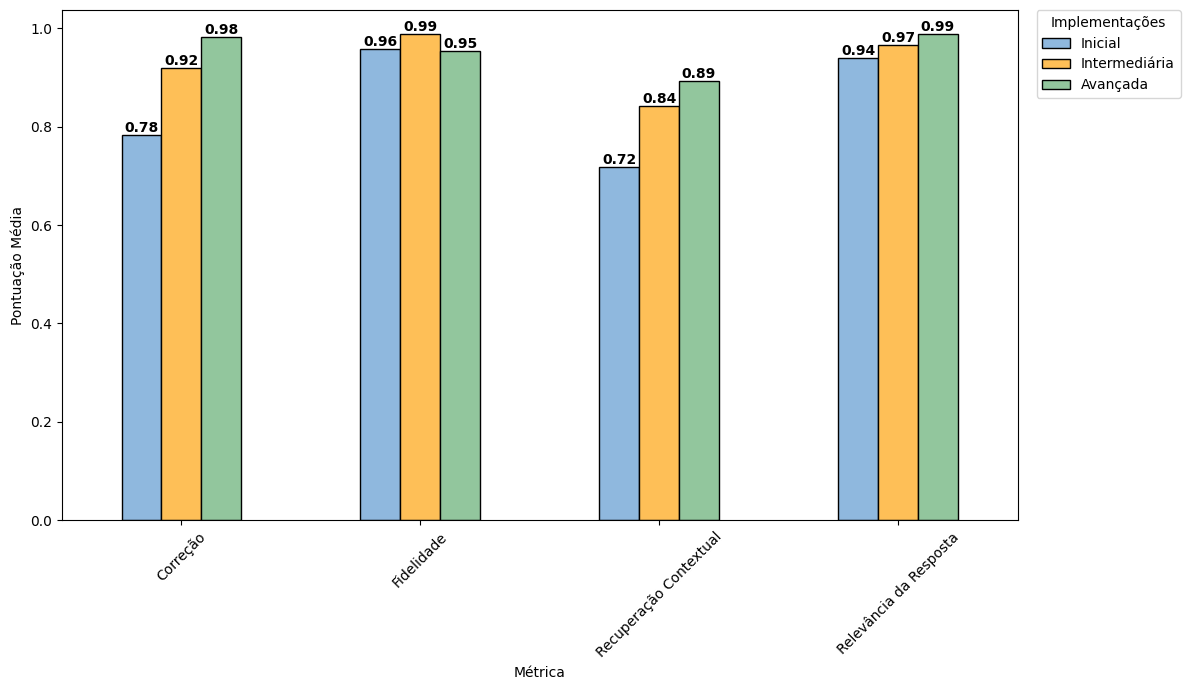

In [ ]:
def plot_metric_comparison(rag_techniques):
    all_metrics = [extract_metrics(df, clean_name(tech_name)) for tech_name, df in rag_techniques.items()]
    combined_df = pd.concat(all_metrics)
    pivot_df = combined_df.pivot_table(values='score', index='metric_name', columns='technique', aggfunc='mean')

    ordered_columns = list(rag_techniques.keys())
    pivot_df = pivot_df[ordered_columns]

    ax = pivot_df.plot(kind='bar', figsize=(12, 7), color=['#8FB8DE', '#FEBF57', '#92C69D'], edgecolor='black')
    plt.xlabel('Métrica')
    plt.ylabel('Pontuação Média')
    plt.xticks(rotation=45)

    # Posicionar a legenda fora do gráfico, no canto superior direito
    plt.legend(title='Implementações', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=10, color='black', weight='bold')

    plt.tight_layout()
    plt.show()


plot_metric_comparison(evaluation_results)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_unapproved_cases_by_ppc_and_technique(unapproved_cases_by_technique, percentual_nao_aprovados_por_tecnica, total_perguntas_por_tecnica):
    desired_order = ['Inicial', 'Intermediária', 'Avançada']

    # Ordena as técnicas na ordem desejada
    unapproved_cases_by_technique = unapproved_cases_by_technique.reindex(columns=desired_order)
    percentual_nao_aprovados_por_tecnica = percentual_nao_aprovados_por_tecnica.reindex(columns=desired_order)

    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#8FB8DE', '#FEBF57', '#92C69D'] # Cores para cada técnica
    width = 0.2  # Largura das barras

    ppcs = unapproved_cases_by_technique.index.unique()
    techniques = desired_order

    # Plotar as barras para cada técnica
    for i, technique in enumerate(techniques):
        if technique in unapproved_cases_by_technique.columns:
            values = unapproved_cases_by_technique[technique]
            positions = [x + (i - 1) * width for x in range(len(ppcs))]
            percentages = percentual_nao_aprovados_por_tecnica[technique]

            bars = ax.bar(positions, percentages,
                          width=width,
                          label=technique,
                          color=colors[i % len(colors)])

            # Adicionar rótulos de porcentagem e número de casos
            for j, (value, percent) in enumerate(zip(values, percentages)):
                if not pd.isna(percent):
                    label = f"{percent:.1f}%\n(n={int(value)})"
                    ax.text(positions[j],
                            percent + 0.5,
                            label,
                            ha='center',
                            va='bottom',
                            fontsize=8)

    # # Ajuste de título, rótulos e escala do eixo Y
    # ax.set_title('Percentual de Casos Não Aprovados por PPC e Técnica',
    #              fontsize=12,
    #              pad=15)
    ax.set_xlabel('PPC', fontsize=10, labelpad=8)
    ax.set_ylabel('Percentual de Casos Não Aprovados', fontsize=10, labelpad=8)

    # Define a escala do eixo Y para facilitar a leitura
    ax.set_ylim(0, 100)  # Ajusta o limite máximo do eixo Y para 100%
    ax.set_xticks(range(len(ppcs)))
    ax.set_xticklabels(ppcs, rotation=0, ha='center')

    ax.legend(title='Técnicas',
              bbox_to_anchor=(1.02, 1),
              loc='upper left',
              fontsize=8)

    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()

    return fig, ax

def extract_prompt_tokens(dataframe, technique_name):
    token_data = []
    for _, row in dataframe.iterrows():
        metadata = row['additional_metadata']
        token_data.append({
            'technique': technique_name,
            'prompt_tokens': metadata.get('PromptTokens', 0) + 550 if technique_name == 'Avançada' else metadata.get('PromptTokens', 0)
        })
    return pd.DataFrame(token_data)

def clean_technique_name(name):
    return name.rstrip('_')

def plot_token_statistics_table(rag_techniques):
    all_token_data = []

    for technique_name, df in rag_techniques.items():
        technique_clean = clean_technique_name(technique_name)
        token_data = extract_prompt_tokens(df, technique_clean)
        all_token_data.append(token_data)

    combined_token_df = pd.concat(all_token_data)
    token_stats = combined_token_df.groupby('technique')['prompt_tokens'].agg(['min', 'mean', 'max', 'sum']).round()

    ordered_techniques = list(rag_techniques.keys())
    token_stats = token_stats.reindex(ordered_techniques)

    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axis('off')

    col_labels = ["Mínimo", "Média", "Máximo", "Total"]
    row_labels = token_stats.index.tolist()
    cell_text = token_stats.values.tolist()

    table = ax.table(cellText=cell_text,
                     colLabels=col_labels,
                     rowLabels=row_labels,
                     cellLoc='center',
                     loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    for (i, j), cell in table.get_celld().items():
        cell.set_edgecolor("black")
        cell.set_linewidth(1.25)
        if i == 0 or j == -1:
            cell.set_facecolor("#4E79A7")
            cell.set_text_props(color="white", weight="bold")

    # plt.title("Estatísticas de Uso de Prompt Tokens por Implementação", fontsize=14)
    plt.tight_layout()
    plt.show()


def combine_failed_inputs_with_ppc_and_aggregated_metrics(rag_techniques):
    """
    Extract and combine failure data with PPC and metrics
    """
    all_questions_list = []
    failed_questions_list = []

    for technique_name, df in rag_techniques.items():
        for _, row in df.iterrows():
            all_questions_list.append({
                'input': row['input'],
                'PPC': row['additional_metadata'].get('Documento'),
                'technique': clean_technique_name(technique_name)
            })
            failed_metrics = [metric['name'] for metric in row['metrics'] if not metric['success']]
            if failed_metrics:
                failed_questions_list.append({
                    'input': row['input'],
                    'PPC': row['additional_metadata'].get('Documento'),
                    'technique': clean_technique_name(technique_name)
                })

    all_questions_df = pd.DataFrame(all_questions_list)
    total_perguntas_por_ppc_tecnica = all_questions_df.groupby(['PPC', 'technique']).size()

    failed_questions_df = pd.DataFrame(failed_questions_list)
    falhas_por_ppc_tecnica = failed_questions_df.groupby(['PPC', 'technique']).size()

    # Calculate failure percentage for each PPC and technique combination
    percentual_falhas_por_tecnica = (falhas_por_ppc_tecnica / total_perguntas_por_ppc_tecnica) * 100

    return falhas_por_ppc_tecnica, percentual_falhas_por_tecnica, total_perguntas_por_ppc_tecnica



In [ ]:
custom_thresholds = {
    'Correctness (GEval)': 0.7,
    'Answer Relevancy': 0.7,
    'Contextual Recall': 0.7,
    'Faithfulness': 0.7
}

base_directory = 'data/mistral-large-latest_/'

naive_df = load_evaluation_df(get_latest_file(base_directory, '*NAIVE_*', 'data/mistral-large-latest_/mistral-large-latest_7cedfd_NAIVE_03_11_2024_10-55-05.json'), custom_thresholds)
naiveft_df = load_evaluation_df(get_latest_file(base_directory, '*NAIVEFT*','data/mistral-large-latest_/mistral-large-latest_80c1c1_NAIVEFT_07_11_2024_22-39-13.json'), custom_thresholds)
advanced_df = load_evaluation_df(get_latest_file(base_directory, '*ADVANCED*', 'data/mistral-large-latest_/mistral-large-latest_d6aa4d_ADVANCED_03_11_2024_00-51-59.json'), custom_thresholds)
advanced_regular_embeddings_df = load_evaluation_df('data/mistral-large-latest_/mistral-large-latest_6ac476_ADVANCED_27_10_2024_14-46-00_combined.json', custom_thresholds)


evaluation_results = {'Inicial': naive_df,
                      'Intermediária': naiveft_df,
                      'Avançada': advanced_df,
                      # 'Teste': advanced_regular_embeddings_df
                      }

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='Implementação', ylabel='Taxa de Sucesso (%)'>)

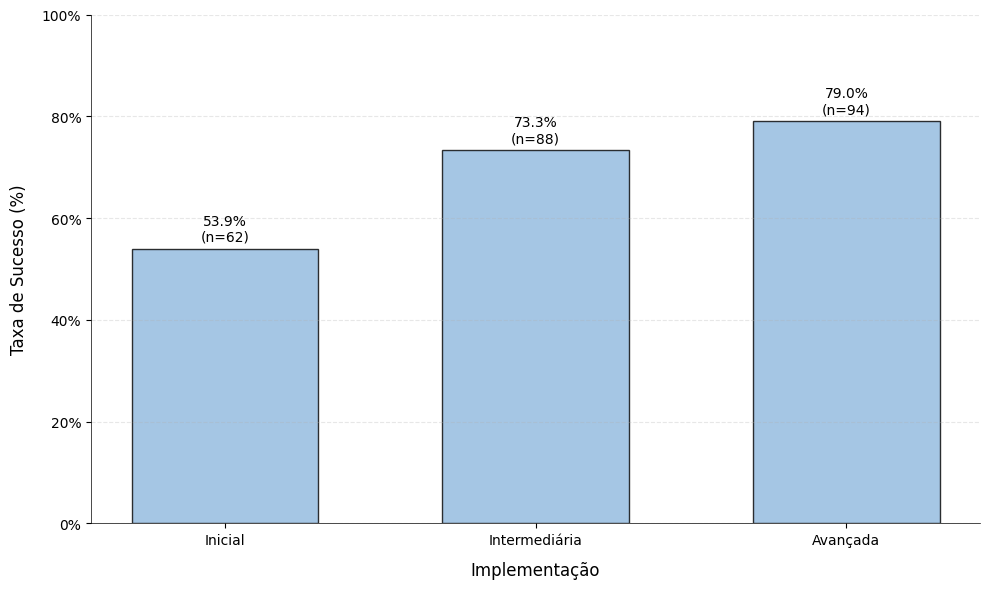

In [ ]:
plot_success_comparison_with_title(evaluation_results)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='PPC', ylabel='Percentual de Casos Não Aprovados'>)

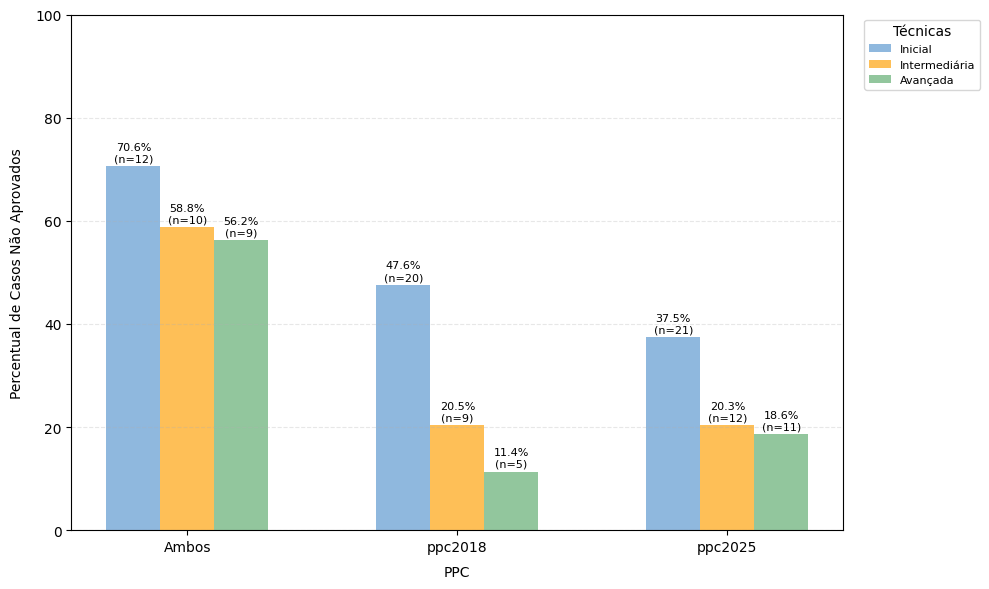

In [ ]:
falhas_por_ppc_tecnica, percentual_falhas_por_tecnica, total_perguntas_por_tecnica = \
    combine_failed_inputs_with_ppc_and_aggregated_metrics(evaluation_results)
plot_unapproved_cases_by_ppc_and_technique(
    falhas_por_ppc_tecnica.unstack(fill_value=0),
    percentual_falhas_por_tecnica.unstack(fill_value=0),
    total_perguntas_por_tecnica
)

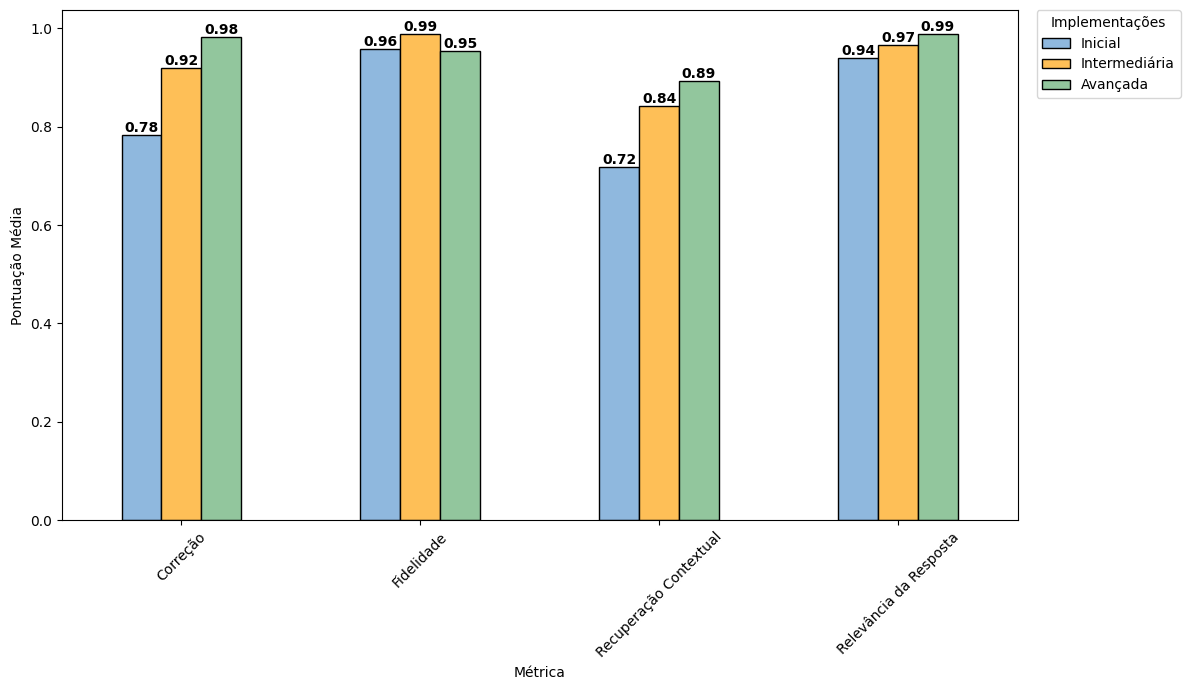

In [ ]:
plot_metric_comparison(evaluation_results)

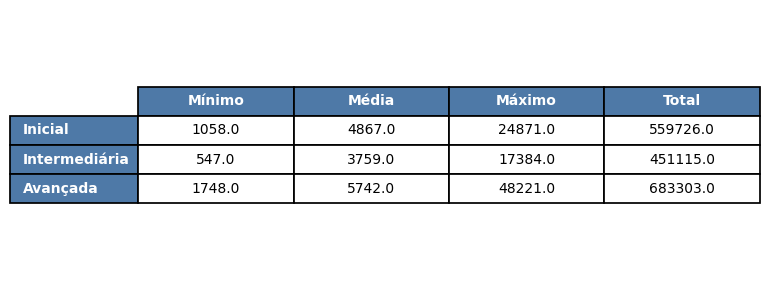

In [ ]:
plot_token_statistics_table(evaluation_results)

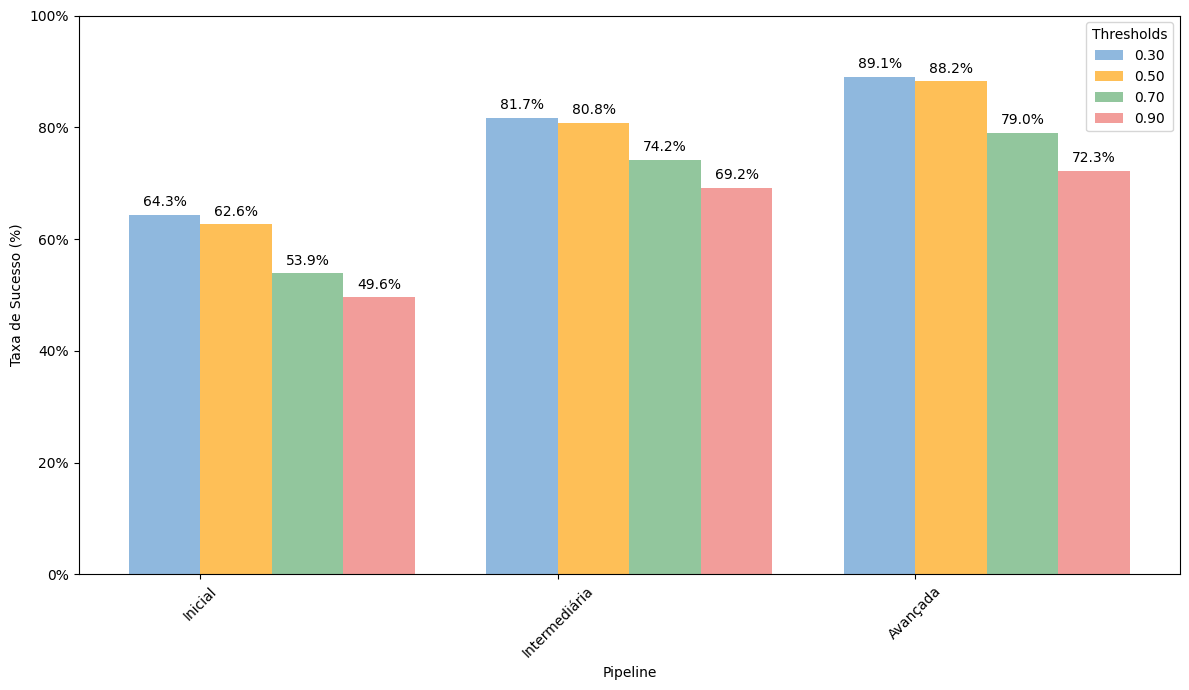

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Dict

# Function to calculate the average of thresholds
def calculate_average_threshold(threshold_dict: Dict[str, float]) -> float:
    return max(threshold_dict.values())

# Modify to accept multiple thresholds
def load_evaluation_df(file_path: str, thresholds_list: List[Dict[str, float]]) -> pd.DataFrame:
    df = pd.read_json(file_path)
    dfs = []

    for thresholds in thresholds_list:
        def recalculate_item_success(row):
            metrics = row['metrics']
            metric_successes = []

            for metric in metrics:
                metric_name = metric['name']
                if metric_name in thresholds:
                    metric['threshold'] = thresholds[metric_name]
                    metric['success'] = metric['score'] >= thresholds[metric_name]
                metric_successes.append(metric['success'])

            row['success'] = all(metric_successes)
            row['threshold'] = calculate_average_threshold(thresholds)  # Adds the average of thresholds
            return row

        df_threshold = df.apply(recalculate_item_success, axis=1)
        df_threshold["metrics"] = df_threshold["metrics"].apply(filter_metrics)
        df_threshold["average_threshold"] = calculate_average_threshold(thresholds)  # Save average as column
        dfs.append(df_threshold)

    return pd.concat(dfs, ignore_index=True)

# Function to plot total success rate with different thresholds
def plot_success_comparison_with_title2(dataframes_per_folder):
    success_data = []

    # Calculate the total success rate for each technique and threshold
    for model_name, df in dataframes_per_folder.items():
        for threshold in df['average_threshold'].unique():
            threshold_data = df[df['average_threshold'] == threshold]
            total_success = threshold_data['success'].mean() * 100
            success_data.append({
                'technique': clean_name(model_name),
                'threshold': threshold,
                'success_rate': total_success
            })

    # Convert to DataFrame for plotting
    success_df = pd.DataFrame(success_data)

    # Organize techniques and thresholds for clear visualization
    success_df['technique'] = pd.Categorical(success_df['technique'], categories=success_df['technique'].unique(), ordered=True)
    success_df = success_df.sort_values(['technique', 'threshold'])

    # Bar plot for success rate comparison by technique and threshold
    fig, ax = plt.subplots(figsize=(12, 7))
    colors = ['#8FB8DE', '#FEBF57', '#92C69D', '#F29D9A']  # Soft colors for thresholds

    # Set the bar width and position
    bar_width = 0.2
    x = range(len(success_df['technique'].unique()))

    # Plot each threshold separately for clear spacing
    for i, (threshold, group_data) in enumerate(success_df.groupby('threshold')):
        # Calculate positions with a slight offset
        positions = [pos + (i * bar_width) for pos in x]
        bars = ax.bar(positions, group_data['success_rate'], bar_width, label=f'{threshold:.2f}', color=colors[i % len(colors)])

        # Add percentage labels above bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

    # Chart settings
    ax.set_xlabel('Pipeline')
    ax.set_ylabel('Taxa de Sucesso (%)')
    ax.set_xticks([pos + bar_width / 2 for pos in x])
    ax.set_xticklabels(success_df['technique'].unique())
    ax.legend(title='Thresholds')
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
custom_thresholds_list = [
    {'Correctness (GEval)': 0.3, 'Answer Relevancy': 0.3, 'Contextual Recall': 0.3, 'Faithfulness': 0.3},
    {'Correctness (GEval)': 0.5, 'Answer Relevancy': 0.5, 'Contextual Recall': 0.5, 'Faithfulness': 0.5},
    {'Correctness (GEval)': 0.7, 'Answer Relevancy': 0.7, 'Contextual Recall': 0.7, 'Faithfulness': 0.7},
    {'Correctness (GEval)': 0.9, 'Answer Relevancy': 0.9, 'Contextual Recall': 0.9, 'Faithfulness': 0.9},
]

naive_df = load_evaluation_df(get_latest_file(base_directory, '*NAIVE_*', 'data/mistral-large-latest_/mistral-large-latest_7cedfd_NAIVE_03_11_2024_10-55-05.json'), custom_thresholds_list)
naiveft_df = load_evaluation_df(get_latest_file(base_directory, '*NAIVEFT*','data/mistral-large-latest_/mistral-large-latest_80c1c1_NAIVEFT_07_11_2024_22-39-13.json'), custom_thresholds_list)
advanced_df = load_evaluation_df(get_latest_file(base_directory, '*ADVANCED*', 'data/mistral-large-latest_/mistral-large-latest_d6aa4d_ADVANCED_03_11_2024_00-51-59.json'), custom_thresholds_list)

evaluation_results = {
    'Inicial': naive_df,
    'Intermediária': naiveft_df,
    'Avançada': advanced_df
}

# Plot with threshold comparison
plot_success_comparison_with_title2(evaluation_results)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def extract_metrics(df):
    metrics_data = []
    for _, row in df.iterrows():
        for metric in row['metrics']:
            metrics_data.append({
                'metric_name': metric['name'],
                'score': metric['score'],
                'success': metric['success']  # Sucesso específico da métrica
            })
    return pd.DataFrame(metrics_data)

def clean_model_name(model_name):
    if model_name.endswith('_'):
        return model_name[:-1]
    return model_name

# Função para garantir que os axes sejam sempre uma lista
def ensure_axes_is_list(axes):
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    return axes

# Função para gerar o gráfico de sucessos e falhas (uma linha com gráficos para cada modelo)
def plot_success_failure(dataframes_per_folder):
    fig, axes = plt.subplots(1, len(dataframes_per_folder), figsize=(20, 5), constrained_layout=True)
    axes = ensure_axes_is_list(axes)

    for idx, (model_name, df) in enumerate(dataframes_per_folder.items()):
        evaluation_model = clean_model_name(model_name)  # Remover o último "_" do nome do modelo
        total_items = len(df)  # Total de itens é o len do df original

        df_metrics = extract_metrics(df)

        success_rate = df_metrics.groupby('metric_name')['success'].value_counts().unstack(fill_value=0)
        success_rate_totals = success_rate.sum(axis=1)

        success_rate.plot(kind='barh', stacked=True, ax=axes[idx], color=['lightcoral', 'lightgreen'])
        axes[idx].set_xlabel('Count')
        axes[idx].set_ylabel('Metric Name')
        axes[idx].set_title(f'Success and Failure ({evaluation_model})')

        for i, (metric, success) in enumerate(success_rate.iterrows()):
            total = success_rate_totals[i]
            axes[idx].text(success[True] - 3, i, f'{int(success[True])} ({(success[True] / total) * 100:.1f}%)', va='center')

    plt.show()

# Função para gerar o gráfico de médias (uma linha com gráficos para cada modelo)
def plot_average_scores(dataframes_per_folder):
    fig, axes = plt.subplots(1, len(dataframes_per_folder), figsize=(20, 5), constrained_layout=True)
    axes = ensure_axes_is_list(axes)

    for idx, (model_name, df) in enumerate(dataframes_per_folder.items()):

        evaluation_model = clean_model_name(model_name)  # Remover o último "_" do nome do modelo
        total_items = len(df)  # Total de itens é o len do df original

        df_metrics = extract_metrics(df)

        avg_scores = df_metrics.groupby('metric_name')['score'].mean()

        bars = axes[idx].barh(avg_scores.index, avg_scores.values, color='lightblue')
        axes[idx].set_xlabel('Average Score')
        axes[idx].set_ylabel('Metric Name')
        axes[idx].set_title(f'Average Score ({evaluation_model})')

        # Adicionando rótulos
        for bar in bars:
            width = bar.get_width()
            axes[idx].text(width - 0.1, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

    plt.show()

# Função para gerar o gráfico de distribuição (uma linha com gráficos para cada modelo)
def plot_score_distribution(dataframes_per_folder):
    fig, axes = plt.subplots(1, len(dataframes_per_folder), figsize=(20, 5), constrained_layout=True)
    axes = ensure_axes_is_list(axes)

    for idx, (model_name, df) in enumerate(dataframes_per_folder.items()):
        evaluation_model = clean_model_name(model_name)  # Remover o último "_" do nome do modelo
        total_items = len(df)  # Total de itens é o len do df original

        df_metrics = extract_metrics(df)

        # Plotando a distribuição de pontuações no eixo `ax`
        df_metrics['score'].plot(kind='hist', bins=10, ax=axes[idx], color='lightgreen', edgecolor='black')
        axes[idx].set_xlabel('Score')
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'Score Distribution ({evaluation_model})')

    plt.show()





<ipython-input-30-939e4fb64b40>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total = success_rate_totals[i]
<ipython-input-30-939e4fb64b40>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total = success_rate_totals[i]
<ipython-input-30-939e4fb64b40>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total = success_rate_totals[i]


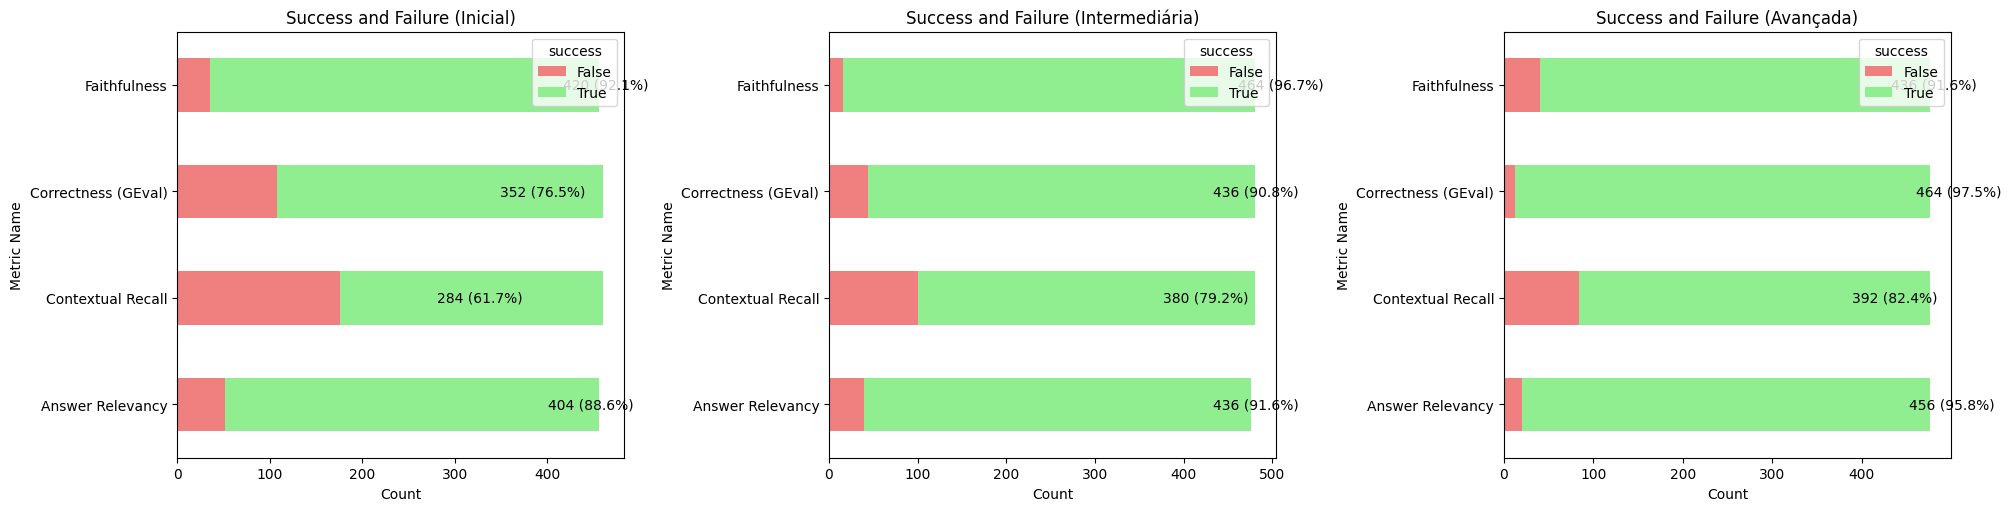

In [ ]:
plot_success_failure(evaluation_results)

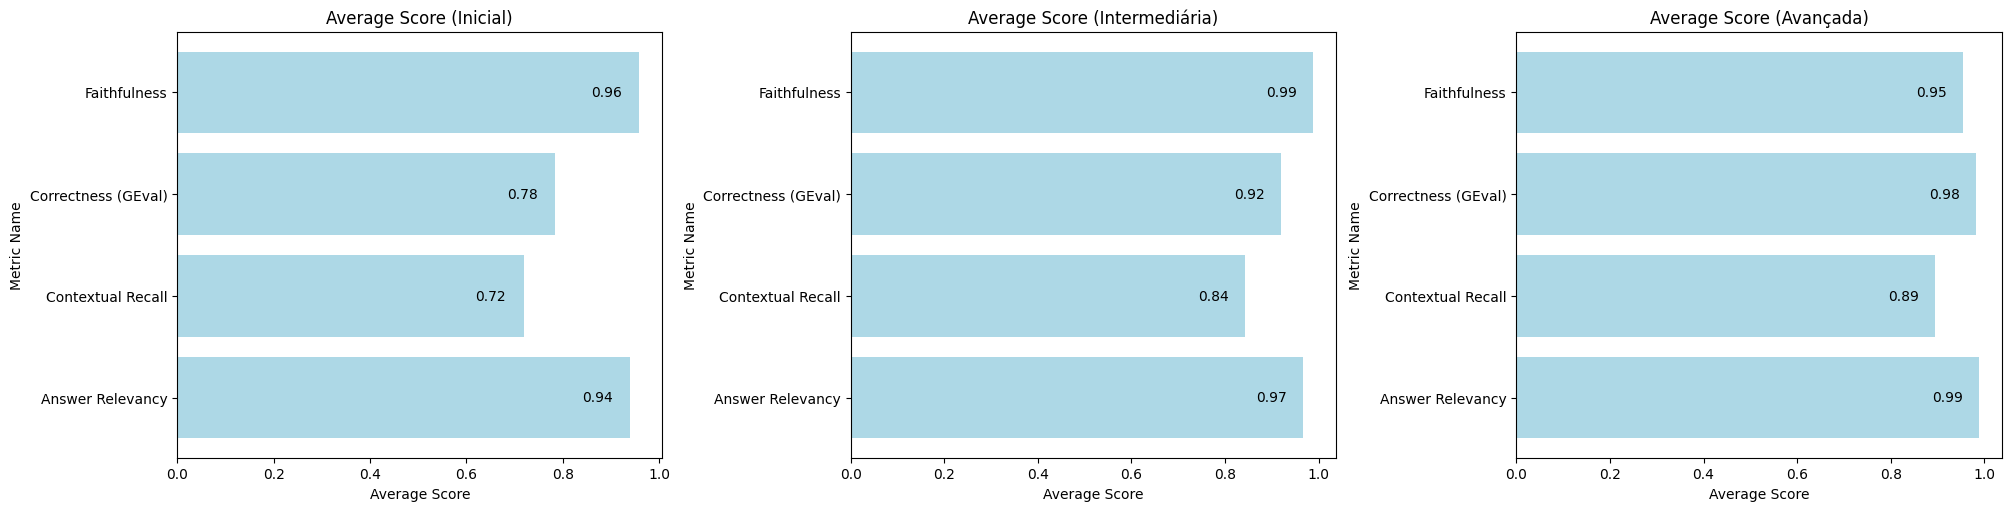

In [ ]:
plot_average_scores(evaluation_results)


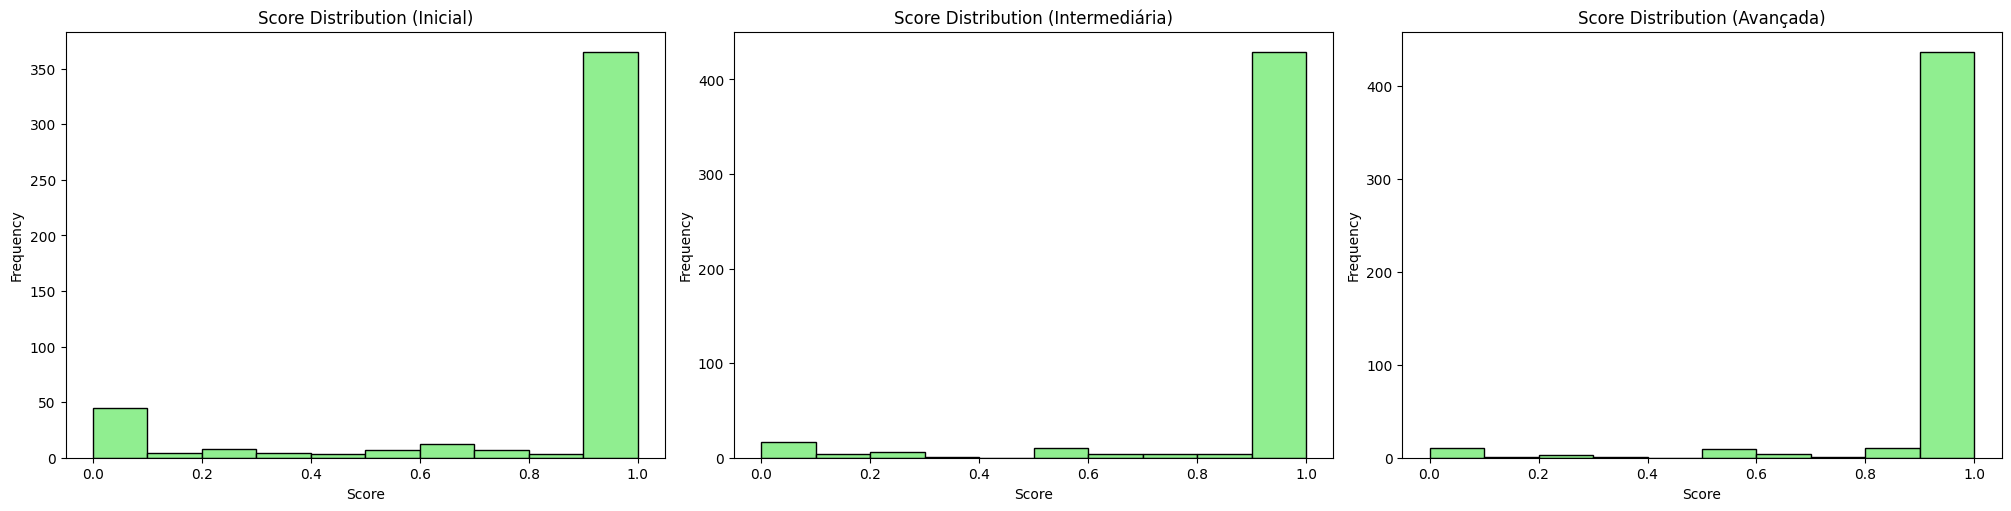

In [ ]:
plot_score_distribution(evaluation_results)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Função para extrair as métricas do dataframe, adicionando o nome da técnica RAG
def extract_metrics(dataframe, technique_name):
    metrics = []
    for _, row in dataframe.iterrows():
        for metric in row['metrics']:
            metrics.append({
                'metric_name': metric['name'],
                'score': metric['score'],
                'technique': technique_name
          })
    return pd.DataFrame(metrics)

# Função para limpar o nome da técnica RAG (caso necessário)
def clean_technique_name(name):
    return name.rstrip('_')

# Função para gerar gráfico de comparação de métricas entre as técnicas de RAG
def plot_metric_comparison(rag_techniques):
    all_metrics = []

    # Extrair as métricas de cada técnica RAG
    for technique_name, df in rag_techniques.items():
        df_metrics = extract_metrics(df, clean_technique_name(technique_name))
        all_metrics.append(df_metrics)

    # Concatenar os dados de todas as técnicas
    combined_metrics_df = pd.concat(all_metrics)

    # Calcular a média dos scores para cada métrica e técnica
    pivot_df = combined_metrics_df.pivot_table(values='score', index='metric_name', columns='technique', aggfunc='mean')

    # Reordenar as colunas na ordem desejada
    ordered_columns = ['Inicial', 'Intermediária', 'Avançada']
    pivot_df = pivot_df[ordered_columns]

    # Plotar o gráfico de barras agrupadas com cores personalizadas
    ax = pivot_df.plot(kind='bar', figsize=(12, 7), color=['#66C2A5', '#FC8D62', '#5353ec'], edgecolor='black')
    plt.title('Comparação de Métricas entre Implementações')
    plt.xlabel('Métrica')
    plt.ylabel('Pontuação Média')
    plt.xticks(rotation=45)
    plt.legend(title='Implementações')

    # Adicionar labels de pontuação acima de cada barra
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black', weight='bold')

    plt.tight_layout()
    plt.show()


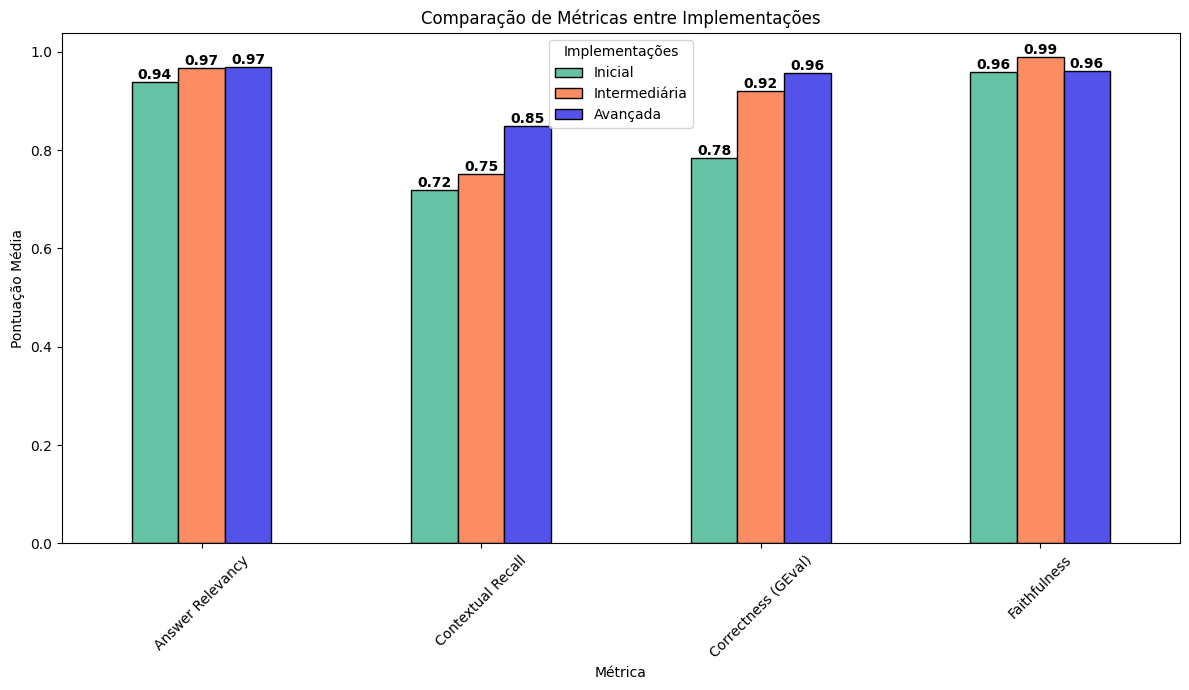

In [ ]:
# Chamando a função para gerar o gráfico de comparação
plot_metric_comparison(evaluation_results)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def clean_technique_name(name):
    return name.rstrip('_')

def plot_success_comparison_with_title(rag_techniques):
    """
    Plots success rates for different RAG techniques with enhanced visualization
    """
    success_data = []

    # Calculate success rates for each RAG technique
    for technique_name, df in rag_techniques.items():
        true_count = df['success'].value_counts().get(True, 0)
        total_count = len(df)
        percentage = (true_count / total_count) * 100
        success_data.append({
            'technique': clean_technique_name(technique_name),
            'success_count': true_count,
            'total_count': total_count,
            'percentage': percentage
        })

    # Convert to DataFrame and sort by technique name
    success_df = pd.DataFrame(success_data)
    # Reorder techniques (Inicial, Intermediária, Avançada)
    technique_order = ['Inicial', 'Intermediária', 'Avançada']
    success_df['technique'] = pd.Categorical(success_df['technique'], categories=technique_order, ordered=True)
    success_df = success_df.sort_values('technique')

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars
    bars = ax.bar(success_df['technique'],
                 success_df['percentage'],
                 color='#4682B4',  # Steel blue
                 edgecolor='black',
                 width=0.6,
                 alpha=0.8)

    # Customize the plot
    ax.set_title('Taxa de Sucesso por Implementação',
                fontsize=14,
                pad=20,
                weight='bold')
    ax.set_xlabel('Implementação', fontsize=12, labelpad=10)
    ax.set_ylabel('Taxa de Sucesso (%)', fontsize=12, labelpad=10)

    # Add percentage signs to y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

    # Set y-axis limits from 0 to 100 with grid
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        idx = bars.index(bar)
        success_count = success_df.iloc[idx]['success_count']
        total_count = success_df.iloc[idx]['total_count']

        # Add percentage and counts
        ax.text(bar.get_x() + bar.get_width()/2, height + 1,
                f'{height:.1f}%\n(n={success_count})',
                ha='center', va='bottom',
                fontsize=10)

    # Add subtle spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

    # Adjust layout
    plt.tight_layout()

    return fig, ax


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Taxa de Sucesso por Implementação'}, xlabel='Implementação', ylabel='Taxa de Sucesso (%)'>)

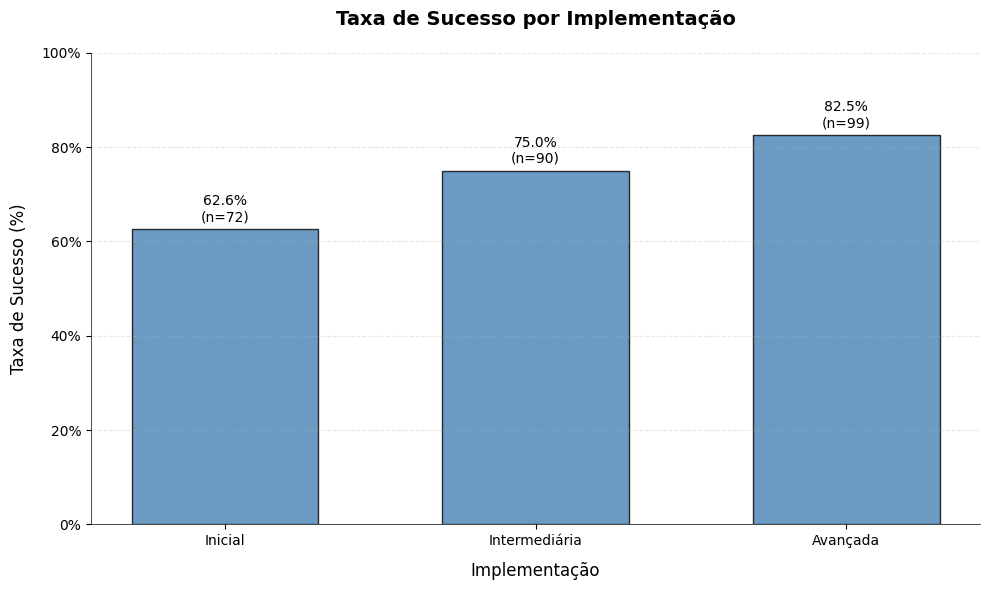

In [ ]:
plot_success_comparison_with_title(evaluation_results)

In [ ]:
def combine_failed_inputs_with_ppc_and_aggregated_metrics(rag_techniques):
    """
    Extract and combine failure data with PPC and metrics
    """
    all_questions_list = []
    failed_questions_list = []

    for technique_name, df in rag_techniques.items():
        for _, row in df.iterrows():
            all_questions_list.append({
                'input': row['input'],
                'PPC': row['additional_metadata'].get('Documento'),
                'technique': clean_technique_name(technique_name)
            })
            failed_metrics = [metric['name'] for metric in row['metrics'] if not metric['success']]
            if failed_metrics:
                failed_questions_list.append({
                    'input': row['input'],
                    'PPC': row['additional_metadata'].get('Documento'),
                    'technique': clean_technique_name(technique_name)
                })

    all_questions_df = pd.DataFrame(all_questions_list)
    total_perguntas_por_ppc_tecnica = all_questions_df.groupby(['PPC', 'technique']).size()

    failed_questions_df = pd.DataFrame(failed_questions_list)
    falhas_por_ppc_tecnica = failed_questions_df.groupby(['PPC', 'technique']).size()

    # Calculate failure percentage for each PPC and technique combination
    percentual_falhas_por_tecnica = (falhas_por_ppc_tecnica / total_perguntas_por_ppc_tecnica) * 100

    return falhas_por_ppc_tecnica, percentual_falhas_por_tecnica, total_perguntas_por_ppc_tecnica

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_unapproved_cases_by_ppc_and_technique(unapproved_cases_by_technique, percentual_nao_aprovados_por_tecnica, total_perguntas_por_tecnica):
    """
    Plot unapproved cases by PPC and technique with improved labels
    """
    # Define the desired order of techniques
    desired_order = ['Inicial', 'Intermediária', 'Avançada']

    # Reorder the columns according to the desired order
    unapproved_cases_by_technique = unapproved_cases_by_technique.reindex(columns=desired_order)
    percentual_nao_aprovados_por_tecnica = percentual_nao_aprovados_por_tecnica.reindex(columns=desired_order)

    fig, ax = plt.subplots(figsize=(10, 6))  # Reduced figure size
    colors = ['#FF6347', '#4682B4', '#FFD700']  # Colors for each technique
    width = 0.2  # Bar width

    # Get unique PPCs
    ppcs = unapproved_cases_by_technique.index.unique()
    techniques = desired_order

    # Plot bars for each technique
    for i, technique in enumerate(techniques):
        if technique in unapproved_cases_by_technique.columns:
            values = unapproved_cases_by_technique[technique]
            positions = [x + (i - 1) * width for x in range(len(ppcs))]
            percentages = percentual_nao_aprovados_por_tecnica[technique]

            bars = ax.bar(positions, percentages,
                         width=width,
                         label=technique,
                         color=colors[i % len(colors)])

            # Add value labels with test cases in parentheses
            for j, (value, percent) in enumerate(zip(values, percentages)):
                if not pd.isna(percent):
                    label = f"{percent:.1f}%\n(n={int(value)})"  # Changed format to show n=X
                    ax.text(positions[j],
                           percent + 0.5,
                           label,
                           ha='center',
                           va='bottom',
                           fontsize=8)  # Reduced font size

    # Customize plot
    ax.set_title('Percentual de Casos Não Aprovados por PPC e Técnica',
                fontsize=12,
                pad=15)
    ax.set_xlabel('PPC', fontsize=10, labelpad=8)
    ax.set_ylabel('Percentual de Casos Não Aprovados', fontsize=10, labelpad=8)

    # Set x-axis ticks and labels
    ax.set_xticks(range(len(ppcs)))
    ax.set_xticklabels(ppcs, rotation=0, ha='center')  # Removed rotation

    # Add legend
    ax.legend(title='Técnicas',
             bbox_to_anchor=(1.02, 1),  # Adjusted position
             loc='upper left',
             fontsize=8)  # Reduced font size

    # Add grid for better readability
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    return fig, ax

import pandas as pd
import matplotlib.pyplot as plt

# Função para extrair dados de uso de tokens, focando em PromptTokens
def extract_prompt_tokens(dataframe, technique_name):
    token_data = []
    for _, row in dataframe.iterrows():
        metadata = row['additional_metadata']
        token_data.append({
            'technique': technique_name,
            'prompt_tokens': metadata.get('PromptTokens', 0)
        })
    return pd.DataFrame(token_data)

# Função para limpar o nome da técnica
def clean_technique_name(name):
    return name.rstrip('_')

# Função para criar uma tabela estilizada com matplotlib
def plot_token_statistics_table(rag_techniques):
    all_token_data = []

    # Extrair dados de tokens para cada técnica
    for technique_name, df in rag_techniques.items():
        technique_clean = clean_technique_name(technique_name)
        token_data = extract_prompt_tokens(df, technique_clean)
        all_token_data.append(token_data)

    # Concatenar os dados e calcular estatísticas
    combined_token_df = pd.concat(all_token_data)
    token_stats = combined_token_df.groupby('technique')['prompt_tokens'].agg(['min', 'mean', 'max', 'sum']).round()

    # Reordenar as técnicas
    ordered_techniques = ["Inicial", "Intermediária", "Avançada"]
    token_stats = token_stats.reindex(ordered_techniques)

    # Criar uma visualização tabular
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axis('off')  # Remover o eixo

    # Configuração da tabela
    col_labels = ["Mínimo", "Média", "Máximo", "Total"]
    row_labels = token_stats.index.tolist()
    cell_text = token_stats.values.tolist()

    # Adicionar a tabela
    table = ax.table(cellText=cell_text,
                     colLabels=col_labels,
                     rowLabels=row_labels,
                     cellLoc='center',
                     loc='center')

    # Estilizar a tabela
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Estilo das células, com verificação de existência
    for (i, j), cell in table.get_celld().items():
        cell.set_edgecolor("black")
        cell.set_linewidth(1.25)
        if i == 0 or j == -1:
            cell.set_facecolor("#4E79A7")
            cell.set_text_props(color="white", weight="bold")

    plt.title("Estatísticas de Uso de Prompt Tokens por Implementação", fontsize=14)
    plt.tight_layout()
    plt.show()

# Exemplo de uso com os dados
# plot_token_statistics_table(evaluation_results)


# Example usage:
# falhas_por_ppc_tecnica, percentual_falhas_por_tecnica, total_perguntas_por_tecnica = \
#     combine_failed_inputs_with_ppc_and_aggregated_metrics(evaluation_results)
# plot_unapproved_cases_by_ppc_and_technique(
#     falhas_por_ppc_tecnica.unstack(fill_value=0),
#     percentual_falhas_por_tecnica.unstack(fill_value=0),
#     total_perguntas_por_tecnica
# )

In [ ]:
failed_inputs_combined_with_ppc = combine_failed_inputs_with_ppc_and_aggregated_metrics(evaluation_results)
failed_inputs_combined_with_ppc.head()

In [ ]:
failed_inputs_combined_with_ppc

In [ ]:
# Contar o número de falhas por PPC
falhas_por_ppc = failed_inputs_combined_with_ppc['PPC'].value_counts()

# Exibir os resultados
print(falhas_por_ppc)



In [ ]:
# Calcular o número total de entradas por PPC
total_por_ppc = evaluations_results['PPC'].value_counts()

# Contar o número de falhas por PPC
falhas_por_ppc = failed_inputs_combined_with_ppc['PPC'].value_counts()

# Calcular a porcentagem de acertos
acertos_por_ppc = total_por_ppc - falhas_por_ppc
percentual_acertos = (acertos_por_ppc / total_por_ppc) * 100

# Plotar o gráfico de barras
fig, ax = plt.subplots(figsize=(8, 6))
percentual_acertos.plot(kind='bar', color=['#66C2A5', '#FC8D62'], ax=ax)  # Cores agradáveis
ax.set_title('Porcentagem de Acertos por PPC')
ax.set_xlabel('PPC')
ax.set_ylabel('Porcentagem de Acertos')

# Adicionar rótulos de porcentagem acima de cada barra
for index, value in enumerate(percentual_acertos):
    ax.text(index, value + 2, f"{value:.1f}%", ha='center')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Função para extrair dados de uso de tokens, focando em PromptTokens
def extract_prompt_tokens(dataframe, technique_name):
    token_data = []
    for _, row in dataframe.iterrows():
        metadata = row['additional_metadata']
        token_data.append({
            'technique': technique_name,
            'prompt_tokens': metadata.get('PromptTokens', 0)
        })
    return pd.DataFrame(token_data)

# Função para gerar um "dashboard" de estatísticas de PromptTokens
def plot_prompt_token_dashboard(rag_techniques):
    all_token_data = []

    # Extrair dados de tokens para cada técnica
    for technique_name, df in rag_techniques.items():
        technique_clean = clean_technique_name(technique_name)
        token_data = extract_prompt_tokens(df, technique_clean)
        all_token_data.append(token_data)

    # Concatenar os dados
    combined_token_df = pd.concat(all_token_data)

    # Calcular estatísticas por técnica
    token_stats = combined_token_df.groupby('technique')['prompt_tokens'].agg(['min', 'mean', 'max', 'sum'])

    # Criar um único painel para visualização
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)

    # Gráfico 1: Máximo de Prompt Tokens
    ax1 = axes[0, 0]
    token_stats['max'].plot(kind='bar', color='#FF6347', ax=ax1, width=0.4)
    ax1.set_title('Máximo de Prompt Tokens')
    ax1.set_xlabel('Técnica RAG')
    ax1.set_ylabel('Máximo de Tokens')
    ax1.tick_params(axis='x', rotation=0)
    for index, value in enumerate(token_stats['max']):
        ax1.text(index, value + 10, f"{value:.0f}", ha='center')

    # Gráfico 2: Média de Prompt Tokens
    ax2 = axes[0, 1]
    token_stats['mean'].plot(kind='bar', color='#4682B4', ax=ax2, width=0.4)
    ax2.set_title('Média de Prompt Tokens')
    ax2.set_xlabel('Técnica RAG')
    ax2.set_ylabel('Média de Tokens')
    ax2.tick_params(axis='x', rotation=0)
    for index, value in enumerate(token_stats['mean']):
        ax2.text(index, value + 10, f"{value:.0f}", ha='center')

    # Gráfico 3: Mínimo de Prompt Tokens
    ax3 = axes[1, 0]
    token_stats['min'].plot(kind='bar', color='#32CD32', ax=ax3, width=0.4)
    ax3.set_title('Mínimo de Prompt Tokens')
    ax3.set_xlabel('Técnica RAG')
    ax3.set_ylabel('Mínimo de Tokens')
    ax3.tick_params(axis='x', rotation=0)
    for index, value in enumerate(token_stats['min']):
        ax3.text(index, value + 10, f"{value:.0f}", ha='center')

    # Gráfico 4: Total de Prompt Tokens
    ax4 = axes[1, 1]
    token_stats['sum'].plot(kind='bar', color='#8A2BE2', ax=ax4, width=0.4)
    ax4.set_title('Total de Uso de Prompt Tokens')
    ax4.set_xlabel('Técnica RAG')
    ax4.set_ylabel('Total de Tokens')
    ax4.tick_params(axis='x', rotation=0)
    for index, value in enumerate(token_stats['sum']):
        ax4.text(index, value + 1000, f"{value:.0f}", ha='center')

    plt.suptitle('Estatísticas de Uso de Prompt Tokens por Técnica RAG')
    plt.show()


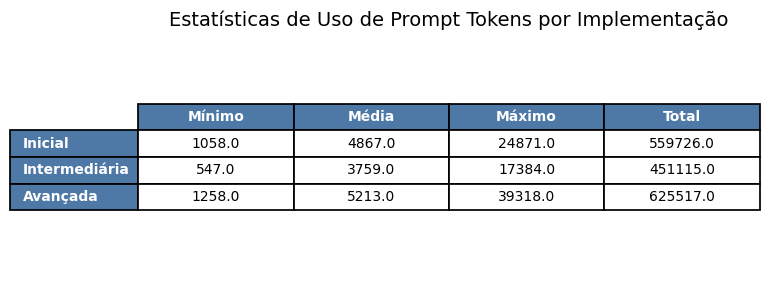

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Função para extrair dados de uso de tokens, focando em PromptTokens
def extract_prompt_tokens(dataframe, technique_name):
    token_data = []
    for _, row in dataframe.iterrows():
        metadata = row['additional_metadata']
        token_data.append({
            'technique': technique_name,
            'prompt_tokens': metadata.get('PromptTokens', 0)
        })
    return pd.DataFrame(token_data)

# Função para limpar o nome da técnica
def clean_technique_name(name):
    return name.rstrip('_')

# Função para criar uma tabela estilizada com matplotlib
def plot_token_statistics_table(rag_techniques):
    all_token_data = []

    # Extrair dados de tokens para cada técnica
    for technique_name, df in rag_techniques.items():
        technique_clean = clean_technique_name(technique_name)
        token_data = extract_prompt_tokens(df, technique_clean)
        all_token_data.append(token_data)

    # Concatenar os dados e calcular estatísticas
    combined_token_df = pd.concat(all_token_data)
    token_stats = combined_token_df.groupby('technique')['prompt_tokens'].agg(['min', 'mean', 'max', 'sum']).round()

    # Reordenar as técnicas
    ordered_techniques = ["Inicial", "Intermediária", "Avançada"]
    token_stats = token_stats.reindex(ordered_techniques)

    # Criar uma visualização tabular
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axis('off')  # Remover o eixo

    # Configuração da tabela
    col_labels = ["Mínimo", "Média", "Máximo", "Total"]
    row_labels = token_stats.index.tolist()
    cell_text = token_stats.values.tolist()

    # Adicionar a tabela
    table = ax.table(cellText=cell_text,
                     colLabels=col_labels,
                     rowLabels=row_labels,
                     cellLoc='center',
                     loc='center')

    # Estilizar a tabela
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Estilo das células, com verificação de existência
    for (i, j), cell in table.get_celld().items():
        cell.set_edgecolor("black")
        cell.set_linewidth(1.25)
        if i == 0 or j == -1:
            cell.set_facecolor("#4E79A7")
            cell.set_text_props(color="white", weight="bold")

    plt.title("Estatísticas de Uso de Prompt Tokens por Implementação", fontsize=14)
    plt.tight_layout()
    plt.show()

# Exemplo de uso com os dados
plot_token_statistics_table(evaluation_results)


TypeError: extract_metrics() missing 1 required positional argument: 'technique_name'

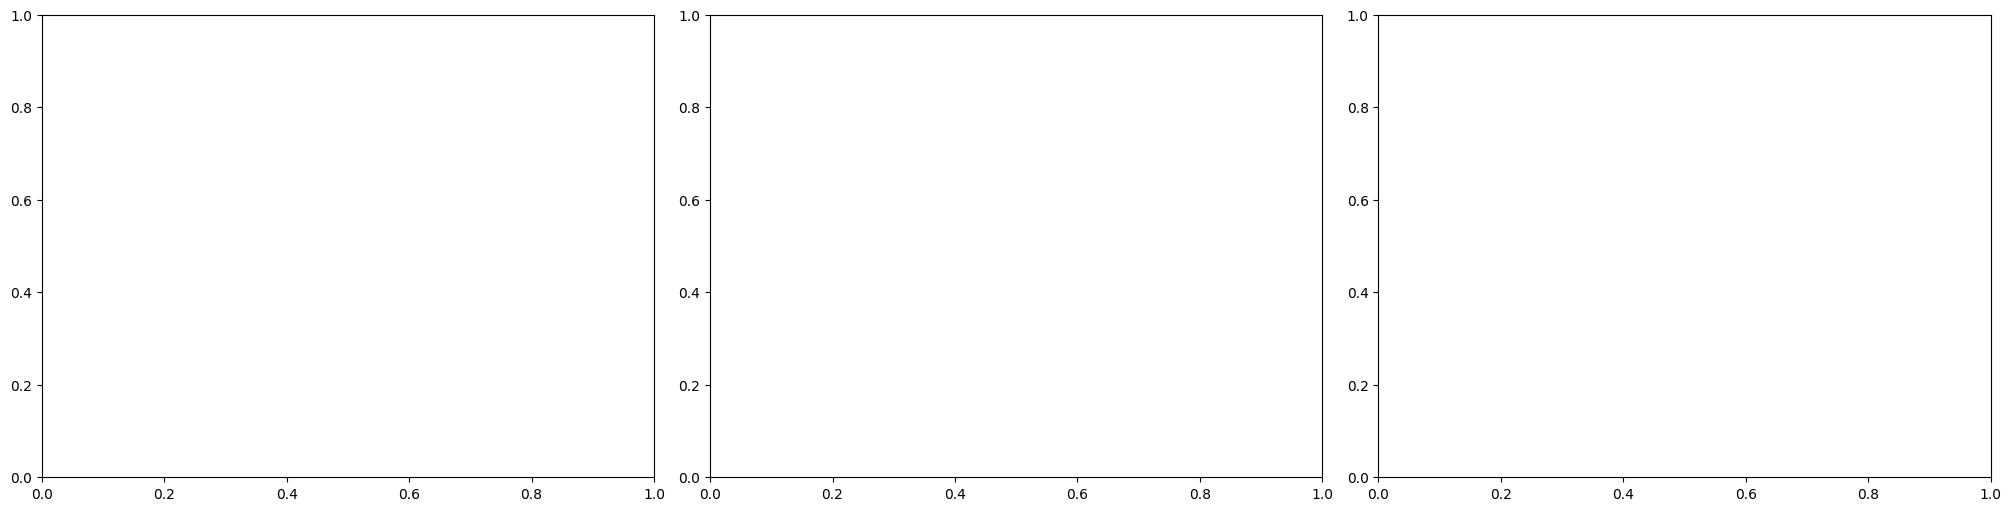

In [ ]:
plot_success_failure(evaluation_results)
plot_average_scores(evaluation_results)
plot_score_distribution(evaluation_results)
plot_metric_comparison(evaluation_results)
plot_success_comparison_with_title(evaluation_results)
plot_token_statistics_table(evaluation_results)
